In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
selected_param_file = 'Param_no_VA.csv'
selected_curves_file = 'Curves_no_VA.csv'

In [3]:
param_raw = pd.read_csv(selected_param_file, sep=',',index_col=0)

In [4]:
country = "Italy"

In [5]:
maturities_country_raw = param_raw.loc[:,country+"_Maturities"].iloc[6:]
param_country_raw = param_raw.loc[:,country + "_Values"].iloc[6:]
extra_param = param_raw.loc[:,country + "_Values"].iloc[:6]

In [6]:
relevant_positions = pd.notna(maturities_country_raw.values)

In [7]:
maturities_country = maturities_country_raw.iloc[relevant_positions]

In [8]:
Qb = param_country_raw.iloc[relevant_positions]

In [9]:
curve_raw = pd.read_csv(selected_curves_file, sep=',',index_col=0)

In [10]:
curve_country = curve_raw.loc[:,country]

In [11]:
# Maturity of observations:
M_Obs = np.transpose(np.array(maturities_country.values))

# Ultimate froward rate ufr represents the rate to which the rate curve will converge as time increases:
ufr = extra_param.iloc[3]/100

# Convergence speed parameter alpha controls the speed at which the curve converges towards the ufr from the last liquid point:
alpha = extra_param.iloc[4]

# For which maturities do we want the SW algorithm to calculate the rates. In this case, for every year up to 150:
M_Target = np.transpose(np.arange(1,151)) 

# Qb calibration vector published by EIOPA for the curve calibration:
Qb = np.transpose(np.array(Qb.values))

In [12]:
import numpy as np

def sw_extrapolate(m_target, m_obs, Qb, ufr, alpha, eps = 0.00001):
    """Interpolate or extrapolate rates for targeted maturities using a Smith-Wilson algorithm.
       sw_extrapolate(m_target, m_obs, Qb, ufr, alpha) calculates the rates for maturities specified in M_Target using the calibration vector b.
    Args:
        m_target (ndarray): k x 1 array of targeted bond maturities.
        m_obs (ndarray): n x 1 array of observed bond maturities used for calibration.
        Qb (ndarray): n x 1 array of calibration vector calculated on observed bonds.
        ufr (float): Ultimate forward rate.
        alpha (float): Convergence speed parameter.
        eps (float): Initial increment to calculate the instantaneous spot rate

    Returns:
        ndarray: k x 1 array of targeted rates for zero-coupon bonds with maturity from m_target.

    For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf
    """
    def sw_heart(u, v, alpha):
        """Calculate the heart of the Wilson function. SWHeart(u, v, alpha) calculates the matrix H (Heart of the Wilson function) for maturities specified by vectors u and v. The formula is taken from the EIOPA technical specifications paragraph 132.

        Args:
            u (ndarray): n_1 x 1 vector of maturities.
            v (ndarray): n_2 x 1 vector of maturities.
            alpha (float): Convergence speed parameter.

        Returns:
            ndarray: n_1 x n_2 matrix representing the Heart of the Wilson function.
        """
        u_mat = np.tile(u, [v.size, 1]).transpose()
        v_mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_mat + v_mat) + np.exp(-alpha * (u_mat + v_mat)) - alpha * np.absolute(u_mat - v_mat) - np.exp(-alpha * np.absolute(u_mat - v_mat)))

    h = sw_heart(m_target, m_obs, alpha) # Heart of the Wilson function from paragraph 132
    p = np.exp(-np.log(1 + ufr) * m_target) + np.diag(np.exp(-np.log(1 + ufr) * m_target)) @ h @ Qb # Discount pricing function for targeted maturities from paragraph 147

    # If the first element of m_target is zero, replace it with 0.00001 to avoid division by zero error.
    m_target[0] = eps if m_target[0] == 0 else m_target[0]

    return p ** (-1 / m_target) - 1

ToDo

In [14]:
def P0T_f(t, M_Obs,Qb,ufr,alpha):
    if isinstance(t, np.ndarray):
        y0T = sw_extrapolate(np.transpose(t),M_Obs, Qb, ufr, alpha)
        out = np.exp(-y0T*np.transpose(t)) 
    else:
        y0T = sw_extrapolate(np.transpose([t]),M_Obs, Qb, ufr, alpha)
        out = np.exp(-y0T*[t]) 
    return out

In [15]:
def f0T(t, P0T, epsilon):
    out = - (np.log(P0T(t+epsilon))-np.log(P0T(t-dt)))/(2*epsilon)
    return out 

In [16]:
def HW_theta(lambd, sigma, P0T, epsilon):
    theta = lambda t: 1.0/lambd *(f0T(t+dt, P0T, epsilon)-f0T(t-dt, P0T, epsilon))/(2.0*dt) + f0T(t, P0T, epsilon) + sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    return theta

In [17]:
def Paths(NoOfPaths, NoOfSteps, T, P0T, lambd, sigma, epsilon):
    # time step needed for differetiation
    # Original inspiration: https://www.youtube.com/watch?v=BIZdwUDbnDo
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(epsilon, P0T, epsilon) # r(0) = f(0,0) = - partial derivative of log(P_mkt(0,epsilon) w.r.t epsilon)

    theta = HW_theta(lambd, sigma, P0T, epsilon)
    # above the calculation of theta 1/lambda * partial derivative of f(0,t) w.r.t. t + f(0,t) + sigma^2/(2lambda^2)* (1=exp(-2*lambda*t))

    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    M = np.ones([NoOfPaths, NoOfSteps+1])
    R[:,0] = r0
    time = np.zeros([NoOfSteps+1])
    dt = T/float(NoOfSteps)
    
    for i in range(0,NoOfSteps):
        # Making sure the samples from the normal distribution have a mean of 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + sigma* np.power(dt,0.5) * Z[:,i] # Euler discretisation scheme of the differential equation
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1] + R[:,i])*0.5*dt) # Numeric integration
        
        time[i+1] = time[i] + dt

    # Outputs
    paths = {"time":time, "R":R, "M":M}
    return paths

In [18]:
def mainCalculation(NoOfPaths, NoOfSteps, T, lambd, sigma, P0T, dt):

    paths = Paths(NoOfPaths, NoOfSteps, T, P0T, lambd, sigma, dt)
    M = paths["M"]
    ti = paths["time"]
    # Compare the price of an option on a ZCB from Monte Carlo and the analytical expression
    P_tMC = np.zeros([NoOfSteps+1])
    for i in range(0,NoOfSteps+1):
        P_tMC[i] = np.mean(1.0/M[:,i])
    plt.figure(1)
    plt.grid()
    plt.xlabel("T")
    plt.ylabel("P(0,T)")
    plt.plot(ti,P0T(ti))
    plt.plot(ti,P_tMC,"--r")
    plt.legend(["P(0,t) market", "P(0,t) Monte Carlo"])
    plt.title("ZCBs from Hull-White Model")

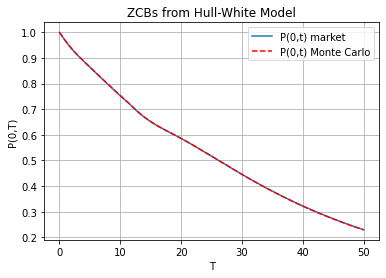

In [19]:
NoOfPaths = 1000
NoOfSteps = 600
T = 50.0 # time horizon in years
lambd = 0.2
sigma = 0.01
dt = 0.5

# ZCB obtained from the Market
P0T = lambda t: P0T_f(t, M_Obs,Qb, ufr, alpha)

mainCalculation(NoOfPaths, NoOfSteps, T, lambd, sigma, P0T, dt)